[View in Colaboratory](https://colab.research.google.com/github/rex-yue-wu/Notebooks/blob/master/textDetNotebookPython3.ipynb)

# Python3 Notebook for Text Detection In The Wild

In [26]:
# install Opencv Python
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# download our text detection repo
!git clone https://github.com/ISICV/TextDetWithScriptID.git  
!cd TextDetWithScriptID && git pull

fatal: destination path 'TextDetWithScriptID' already exists and is not an empty directory.
remote: Counting objects: 4, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/ISICV/TextDetWithScriptID
   910fa0f..bcd0b06  master     -> origin/master
Updating 910fa0f..bcd0b06
Fast-forward
 lib/textDetDec.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [2]:
from __future__ import print_function
import keras
import tensorflow as tf
import numpy as np 
import sys
from matplotlib import pyplot
import os
import cv2
np.set_printoptions(3, suppress=True)
print("keras.version =", keras.__version__)
print("tensorflow.version =", tf.__version__)
print("cv2.version =", cv2.__version__)

Using TensorFlow backend.


keras.version = 2.1.5
tensorflow.version = 1.7.0
cv2.version = 3.4.0


# 1. Set Text Detection Path

In [3]:
repo_root = os.path.join( os.getcwd(),'TextDetWithScriptID' )
print("git repo root =", repo_root)
assert os.path.isdir( repo_root ), "ERROR: can't locate git repo for text detection"
model_dir = os.path.join( repo_root, 'model' )
scriptID_weight = os.path.join( model_dir, 'sciptIDModel.h5' )
assert os.path.isfile( scriptID_weight ), "ERROR: can't locate script-ID classification model"
docum_weight  = os.path.join( model_dir, 'textDetDocumModel.h5' )
assert os.path.isfile( docum_weight ), "ERROR: can't locate text detection model"
scene_weight  = os.path.join( model_dir, 'textDetSceneModel.h5' )
assert os.path.isfile( scene_weight ), "ERROR: can't locate text detection model"

data_dir  = os.path.join( repo_root, 'data' )
lib_dir   = os.path.join( repo_root, 'lib' )
sys.path.insert( 0, lib_dir )
import textDetCore, textDetDec

git repo root = /content/TextDetWithScriptID


# 2. Load Models with Pretrained Weights

## 2.a scriptID model

The scriptID model's output format is a `nb_samples x 7` array, 
where the 1st dimension stands for the sample axis, 
and the 2nd one stands for the scriptID probability of each known script.

More precisely, the seven scriptID classes are:

| **scriptID index** | **scriptID name** | **Country** |
|:------------------:|:-----------------:|:-----------:|
| 0 | NonText | N/A |
| 1 | Latin | US, UK, etc. |
| 2 | Hebrew | Israel |
| 3 | Cyrillic | Russia, Ukraine, etc. | 
| 4 | Arabic | Iran, Saudi Arabia, etc. |
| 5 | Chinese | China, HongKong, etc. |
| 6 | TextButUnknown | N/A |

In [4]:
scriptID = textDetCore.create_scriptID_model()
scriptID.load_weights( scriptID_weight )
print(scriptID.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
scriptIDb1c1-c (Conv2D)      (None, None, None, 16)    2368      
_________________________________________________________________
scriptIDb1c1-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c1-re (Activation) (None, None, None, 16)    0         
_________________________________________________________________
scriptIDb1c2-c (Conv2D)      (None, None, None, 16)    272       
_________________________________________________________________
scriptIDb1c2-bn (BatchNormal (None, None, None, 16)    64        
_________________________________________________________________
scriptIDb1c2-re (Activation) (None, None, None, 16)    0         
__________

## 2.b textDet model
The textDet model's output format is a `nb_samples x height x width x 3` array, where the last dimension is the class dimension. 
  
  |**class index**| **class name** | **color channel**| **Description**|
  |:-------------:|:-------------:|:-------------:|:-------------:|
  | 0 | NonText | Red | Any non-text content |
  | 1 | Border  | Green | Pixels on text borders |
  | 2 | Text    | Blue | Text Pixels |
  
We provide two specialized text detection models for
  - **Word-Level** `SceneText`, e.g. a street-view image.
  - **Line-Level** `DocumentText`, e.g. a scanned letter.
 
One should first review the provided testing examples in **Section 3 and 4** to have a better understanding about `DocumentText` and `SceneText`.

In [0]:
documDet = textDetCore.create_textDet_model()
documDet.load_weights( docum_weight )
sceneDet = textDetCore.create_textDet_model()
sceneDet.load_weights( scene_weight )

# 3. Document Text Detection


## 3.a Decoder API
We provide a simple decoder for document text detection, whose API is defined below

```python
def simple_decoder( file_path,
                    textDet_model,
                    scriptID_model=None,
                    output_dir=None,
                    dom_font=None,
                    dark_text=None,
                    rotated_text=False,
                    proba_threshold=.5,
                    lh_threshold=15,
                    contrast_threshold=24.,
                    return_proba=True,
                    n_jobs=1,
                    verbose=2) :
    """
    INPUTS:
        ------------------------------------------------------------------------
        | Mandentory Parameters
        ------------------------------------------------------------------------
        file_path = str, path to a local file or URL to a web image
        textDet_model = keras model, pretrained text detection model
        scriptID_model = None or keras model, pretrained script ID model
                         if None, then no scriptID classification
        output_dir = None or str or 'SKIP', dir to save detected and corrected text regions,
                     if None, then text regions as JPEG buffers
                     if SKIP, then not save text regions
        ------------------------------------------------------------------------
        | Prior Knowledge Parameters (better performance if they are provided)
        ------------------------------------------------------------------------
        dom_font = int or None, dominant fontsize height in terms of pixels
                   if None, then apply automatic estimation
        dark_text = bool or None, whether texts on image is dark/black or not
                    if None, then apply automatic estimation
        rotated_text = bool, whether text regions are rotated or not
                       if False, then faster decoding is applied
        ------------------------------------------------------------------------
        | Simple Rules to Reject A Text Region
        ------------------------------------------------------------------------
        proba_threshold = float in (0,1), the minimum text probability to accept a text region
        lh_threshold = float, the minimum line height to accept a text region
        contrast_threshold = float in (0,255), the minimum intensity standard deviation to accept a text region
        ------------------------------------------------------------------------
        | Others
        ------------------------------------------------------------------------
        return_proba = bool, if true, return the raw outputs of both models
        n_jobs = int, if greater than 1, use multiple CPUs
        verbose = bool, if true, print out state messages

    OUTPUTS:
            output_lut = dict, containing all decoded results including
                         'filename' -> input image file
                         'resize'   -> resize factor for text detection analysis
                         'md5'      -> image md5 tag
                         'Pr(XXX)'  -> script ID probability of a known scriptID class XXX
                         'bboes'    -> list of bounding box dictionaries, where each element is a dict of
                               'cntx'     -> bbox's x coordinates
                               'cnty'     -> bbox's y coordinates
                               'proba'    -> text probility of this region
                               'area'     -> bbox area
                               'contrast' -> bbox contrast
                               'imgfile'  -> file path the dumped text region image, when output_dir is given
                               'jpgbuf'   -> jpeg buffer for the text region image, when output_dir is None
            proba_map = ( text_proba, script_proba )
                        - text_proba, i.e. a text probability map, size of imgHeight-by-imgWidth-by-3
                        - script proba, i.e. a script ID probability map, size of 1-by-7                                   
    """                                               
```

## 3.b Why do we care about these parameters?

**In short, more prior knowledge, better performance in speed/accuracy.**

Because our model is trained with internal data that might be very different from your testing data. Bring a testing sample to the domain of training samples will largely enhance the text detection performance. 

Among various variations, absolute fontsize in terms of pixels is probably the most important. This is why we want you to provide `dom_font` information, and why we estimate it when its value is NOT provided.

Other parameters like `rotated_text` is helpful to speed up decoding. Because when we know all text regions are not tilted, we can easily parse a text region as a rectgular bounding box. In contrast, when this tag is is ON, we know text regions are of different oritentaions, and one may differ from another. Therefore, we have to spend extra computations to decide the orientation for each individual text regions.

## 3.c How to set these parameters?

**Here are some rule of thumbs**

1. **leave prior knowledge related parameters default values, unless you know how to set properly.**
   - `dom_font`: means the dominant text font's height in terms of pixels (you need to measure this before running text detection).
   - `dark_text`: means whether the input image contains dark texts on a bright background (this parameter should be `True` for most document images)
   - `rotated_text`: means whether or not text regions are all horizontal. When it is `False`, a fast decoder is applied by skipping all roation-related analysis.

2. **if you prefer to apply additional classifiers to reject a text region, set all following thresholds to zeros.**

   - `proba_threshold`: reject a detected region when its overall text probability is lower than specified.
   - `lh_threshold`: reject a detected region when its line height is lower than specified.
   - `contrast_threshold`: reject a detected region when its pixel standard deviation is lower than specified.

## 3.d Document Text Detection without Oriented Text Regions

- Use all default parameters
- unless the case of document text color is not **DARK**, set parameter `dark_text=False`.

18-04-24 08:40:26.43 | INFO: begin text detection for /content/TextDetWithScriptID/data/Passport+copy.jpg
18-04-24 08:40:26.46 | INFO: original image size = (1024,724)
18-04-24 08:40:26.61 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:40:26.62 | INFO: estimated input doc paper=A4
18-04-24 08:40:26.62 | INFO: estimated dominant line height on original is 15 pixels high
18-04-24 08:40:26.62 | INFO: resize input by 1.50 to match line height 22.5
18-04-24 08:40:26.65 | INFO: begin FCN text detection
18-04-24 08:41:04.53 | INFO: done FCN text detection
18-04-24 08:41:04.53 | INFO: begin results dumping
18-04-24 08:41:04.54 | INFO: original image size = (1024,724)
18-04-24 08:41:04.56 | INFO: resize image size = (1536,1086)
18-04-24 08:41:04.59 | INFO: localize horizontal text bounding boxes
18-04-24 08:41:04.61 | INFO: begin save detection results, image mode = image file path
18-04-24 08:41:04.70 | INFO: done text detection for /content/TextDetWithScriptID/data/Passpo

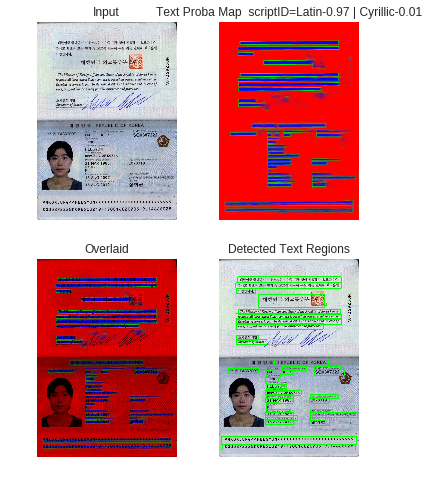

In [28]:
file_path = os.path.join( data_dir,'Passport+copy.jpg')
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, output_dir='/tmp' )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

In [0]:
file_path = os.path.join( data_dir,'crop-rot-out0092.png')
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, output_dir='/tmp'  )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:41:42.00 | INFO: begin text detection for /content/TextDetWithScriptID/data/crop-rot-out0092.png
18-04-24 08:41:42.13 | INFO: original image size = (2700,1800)
18-04-24 08:41:44.87 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:41:44.93 | INFO: estimated input doc paper=A4
18-04-24 08:41:44.93 | INFO: estimated dominant line height on original is 22 pixels high
18-04-24 08:41:44.93 | INFO: resize input by 1.02 to match line height 22.5
18-04-24 08:41:44.93 | INFO: begin FCN text detection


18-04-24 08:01:37.23 | INFO: begin text detection for /content/TextDetWithScriptID/data/JAP_atomu-tanaka-japanese-cover-letter-1-638.jpg
18-04-24 08:01:37.25 | INFO: original image size = (826,638)
18-04-24 08:01:37.30 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:01:37.31 | INFO: estimated input doc paper=letter
18-04-24 08:01:37.31 | INFO: estimated dominant line height on original is 11 pixels high
18-04-24 08:01:37.31 | INFO: resize input by 2.05 to match line height 22.5
18-04-24 08:01:37.33 | INFO: begin FCN text detection
18-04-24 08:01:42.49 | INFO: done FCN text detection
18-04-24 08:01:42.49 | INFO: begin results dumping
18-04-24 08:01:42.50 | INFO: original image size = (826,638)
18-04-24 08:01:42.52 | INFO: resize image size = (1689,1305)
18-04-24 08:01:42.56 | INFO: localize horizontal text bounding boxes
18-04-24 08:01:42.57 | INFO: begin save detection results, image mode = image file path
18-04-24 08:01:42.67 | INFO: done text detection for /conten

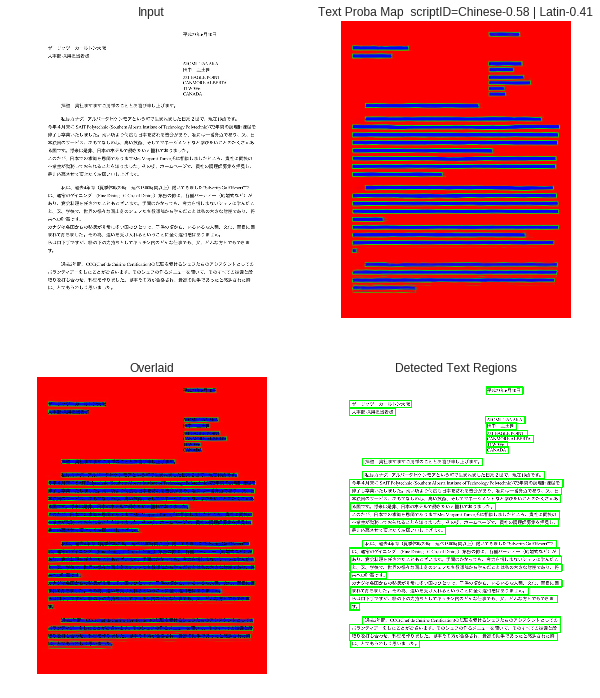

In [0]:
file_path = os.path.join( data_dir,'JAP_atomu-tanaka-japanese-cover-letter-1-638.jpg')
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, output_dir='/tmp'  )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=6 ) 

## 3.e Document Text Detection without Oriented Text Regions

- Use all default parameters except `rotated_text=True`
- Unless the case of document text color is not DARK, set parameter dark_text=False.

18-04-24 08:02:02.19 | INFO: begin text detection for /content/TextDetWithScriptID/data/CVPR2015.png
18-04-24 08:02:02.21 | INFO: original image size = (612,788)
18-04-24 08:02:02.26 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:02:02.26 | INFO: estimated input doc paper=letter
18-04-24 08:02:02.26 | INFO: estimated dominant line height on original is 9 pixels high
18-04-24 08:02:02.27 | INFO: resize input by 2.50 to match line height 22.5
18-04-24 08:02:02.28 | INFO: begin FCN text detection
18-04-24 08:02:08.92 | INFO: done FCN text detection
18-04-24 08:02:08.92 | INFO: begin results dumping
18-04-24 08:02:08.94 | INFO: original image size = (612,788)
18-04-24 08:02:08.95 | INFO: resize image size = (1530,1970)
18-04-24 08:02:09.01 | INFO: localize rotated text bounding boxes
18-04-24 08:02:10.10 | INFO: begin save detection results, image mode = JPEG buffer
18-04-24 08:02:10.68 | INFO: done text detection for /content/TextDetWithScriptID/data/CVPR2015.png
  Pr

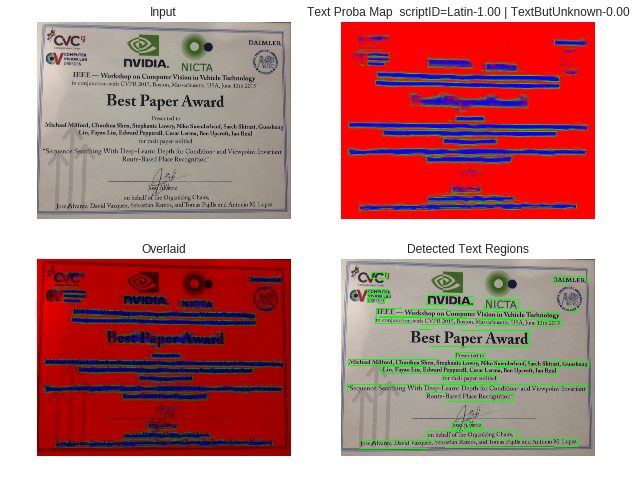

In [0]:
file_path = os.path.join( data_dir,'CVPR2015.png' )
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, rotated_text=True )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:02:37.16 | INFO: begin text detection for /content/TextDetWithScriptID/data/CSS-Past-Paper-Political-Science-2017.jpg
18-04-24 08:02:37.18 | INFO: original image size = (860,725)
18-04-24 08:02:37.24 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:02:37.25 | INFO: estimated input doc paper=letter
18-04-24 08:02:37.25 | INFO: estimated dominant line height on original is 10 pixels high
18-04-24 08:02:37.25 | INFO: resize input by 2.25 to match line height 22.5
18-04-24 08:02:37.28 | INFO: begin FCN text detection
18-04-24 08:02:44.13 | INFO: done FCN text detection
18-04-24 08:02:44.13 | INFO: begin results dumping
18-04-24 08:02:44.14 | INFO: original image size = (860,725)
18-04-24 08:02:44.16 | INFO: resize image size = (1935,1631)
18-04-24 08:02:44.21 | INFO: localize rotated text bounding boxes
18-04-24 08:02:45.22 | INFO: begin save detection results, image mode = JPEG buffer
18-04-24 08:02:45.97 | INFO: done text detection for /content/TextDetWithS

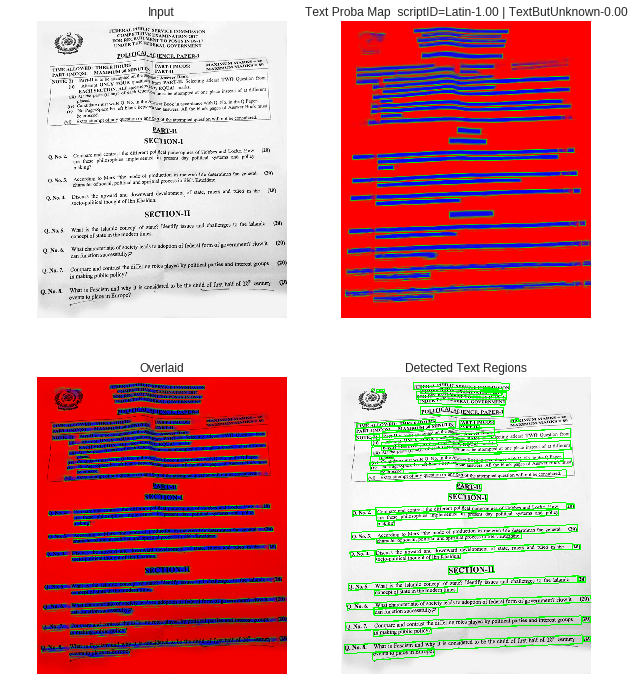

In [0]:
file_path = os.path.join( data_dir,'CSS-Past-Paper-Political-Science-2017.jpg' )
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, rotated_text=True )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False,fh=6 ) 

18-04-24 08:03:06.47 | INFO: begin text detection for /content/TextDetWithScriptID/data/remsen-22-2.jpeg
18-04-24 08:03:06.51 | INFO: original image size = (1639,1259)
18-04-24 08:03:06.92 | INFO: estimated case = DARK TEXT on bright background
18-04-24 08:03:06.94 | INFO: estimated input doc paper=letter
18-04-24 08:03:06.94 | INFO: estimated dominant line height on original is 15 pixels high
18-04-24 08:03:06.94 | INFO: resize input by 1.50 to match line height 22.5
18-04-24 08:03:06.97 | INFO: begin FCN text detection
18-04-24 08:03:16.35 | INFO: done FCN text detection
18-04-24 08:03:16.35 | INFO: begin results dumping
18-04-24 08:03:16.38 | INFO: original image size = (1639,1259)
18-04-24 08:03:16.42 | INFO: resize image size = (2458,1888)
18-04-24 08:03:16.48 | INFO: localize rotated text bounding boxes
18-04-24 08:03:16.78 | INFO: begin save detection results, image mode = JPEG buffer
18-04-24 08:03:17.93 | INFO: done text detection for /content/TextDetWithScriptID/data/remsen-2

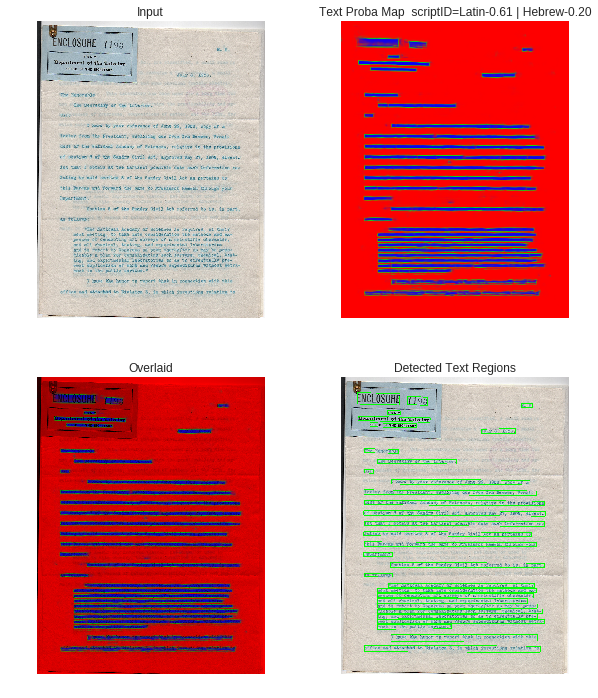

In [0]:
file_path = os.path.join( data_dir,'remsen-22-2.jpeg' )
output_lut, (text_proba, script_proba) = textDetDec.simple_decoder( file_path, documDet, scriptID, rotated_text=True )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=6 )  

# 4. Scene Text Detection


## 4.a Decoder API
Unlike for `DocumentText`, we have a more complicated decoder for scene text detection. This extra complexity is due to the fact that the dominant fontsize assumption may no longer hold for a scene text image, and we can't guess the actual fontsize height based on the input image size. We, therefore, analyze a given scene text image at a number of resolution scales to capature text regions of very different fontsizes.

```python
def lazy_decoder( file_path,
                  textDet_model,
                  scriptID_model=None,
                  num_resolutions=5,
                  output_dir=None,
                  proba_threshold=.33,
                  lh_threshold=8,
                  contrast_threshold=32.,
                  return_proba=True,
                  n_jobs=1,
                  verbose=2) :
    """
    INPUTS:
        ------------------------------------------------------------------------
        | Mandentory Parameters
        ------------------------------------------------------------------------
        file_path = str, path to a local file or URL to a web image
        textDet_model = keras model, pretrained text detection model
        scriptID_model = None or keras model, pretrained script ID model
                         if None, then no scriptID classification
        output_dir = None or str or 'SKIP', dir to save detected and corrected text regions,
                     if None, then text regions as JPEG buffers
                     if SKIP, then not save text regions
        ------------------------------------------------------------------------
        | Simple Rules to Reject A Text Region
        ------------------------------------------------------------------------
        proba_threshold = float in (0,1), the minimum text probability to accept a text region
        lh_threshold = float, the minimum line height to accept a text region
        contrast_threshold = float in (0,255), the minimum intensity standard deviation to accept a text region
        ------------------------------------------------------------------------
        | Others
        ------------------------------------------------------------------------
        return_proba = bool, if true, return the raw outputs of both models
        n_jobs = int, if greater than 1, use multiple CPUs
        num_resolutions = int, default 3
        verbose = bool, if true, print out state messages

    OUTPUTS:
        output_lut = dict, containing all decoded results including
                     'filename' -> input image file
                     'resize'   -> resize factor for text detection analysis
                     'md5'      -> image md5 tag
                     'Pr(XXX)'  -> script ID probability of a known scriptID class XXX
                     'bboes'    -> list of bounding box dictionaries, where each element is a dict of
                           'cntx'     -> bbox's x coordinates
                           'cnty'     -> bbox's y coordinates
                           'proba'    -> text probility of this region
                           'area'     -> bbox area
                           'contrast' -> bbox contrast
                           'imgfile'  -> file path the dumped text region image, when output_dir is given
                           'jpgbuf'   -> jpeg bufferfor the text region image, when output_dir is None
        proba_map = ( text_proba, script_proba )
                    - text_proba, i.e. a text probability map, size of imgHeight-by-imgWidth-by-3
                    - script proba, i.e. a script ID probability map, size of 1-by-7
    """                                            
```

**NOTE**: we remove the parameters `dom_font`, `dark_text`, and `rotated_text` in the scene text detection API, but introduce one new parameter `num_resolutions` to specify the number of resolutions.

18-04-24 08:03:39.78 | INFO: begin text detection for https://www.euractiv.com/wp-content/uploads/sites/2/2017/12/Protest-in-Kyiv-800x450.jpg
18-04-24 08:03:40.70 | INFO: original image size = (450,800)
18-04-24 08:03:40.71 | INFO: begin text detection for factor 0
18-04-24 08:03:40.71 | INFO: resize input by 0.57 to match line height (256, 455)
18-04-24 08:03:41.81 | INFO: done text detection for factor 0
18-04-24 08:03:41.82 | INFO: begin text detection for factor 1
18-04-24 08:03:41.82 | INFO: resize input by 1.43 to match line height (642, 1141)
18-04-24 08:03:44.31 | INFO: done text detection for factor 1
18-04-24 08:03:44.32 | INFO: begin text detection for factor 2
18-04-24 08:03:44.32 | INFO: resize input by 2.28 to match line height (1028, 1827)
18-04-24 08:03:48.82 | INFO: done text detection for factor 2
18-04-24 08:03:48.84 | INFO: begin text detection for factor 3
18-04-24 08:03:48.84 | INFO: resize input by 3.14 to match line height (1414, 2513)
18-04-24 08:03:56.31 | INF

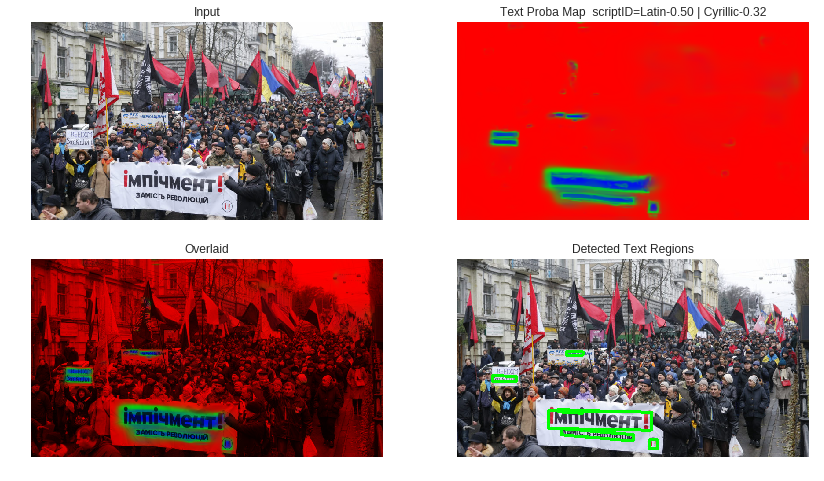

In [0]:
file_path = 'https://www.euractiv.com/wp-content/uploads/sites/2/2017/12/Protest-in-Kyiv-800x450.jpg'
output_lut, (text_proba, script_proba) = textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:04:13.49 | INFO: begin text detection for https://media2.s-nbcnews.com/i/newscms/2018_13/2383341/180331-stephon-clark-protest-ew-755p_bce3a0a92f27d0671f85d727e58139bb.jpg
18-04-24 08:04:14.08 | INFO: original image size = (1654,2500)
18-04-24 08:04:14.10 | INFO: begin text detection for factor 0
18-04-24 08:04:14.10 | INFO: resize input by 0.15 to match line height (256, 386)
18-04-24 08:04:14.78 | INFO: done text detection for factor 0
18-04-24 08:04:14.81 | INFO: begin text detection for factor 1
18-04-24 08:04:14.81 | INFO: resize input by 0.44 to match line height (721, 1090)
18-04-24 08:04:17.50 | INFO: done text detection for factor 1
18-04-24 08:04:17.55 | INFO: begin text detection for factor 2
18-04-24 08:04:17.55 | INFO: resize input by 0.72 to match line height (1186, 1793)
18-04-24 08:04:22.67 | INFO: done text detection for factor 2
18-04-24 08:04:22.68 | INFO: begin text detection for factor 3
18-04-24 08:04:22.68 | INFO: resize input by 1.00 to match line hei

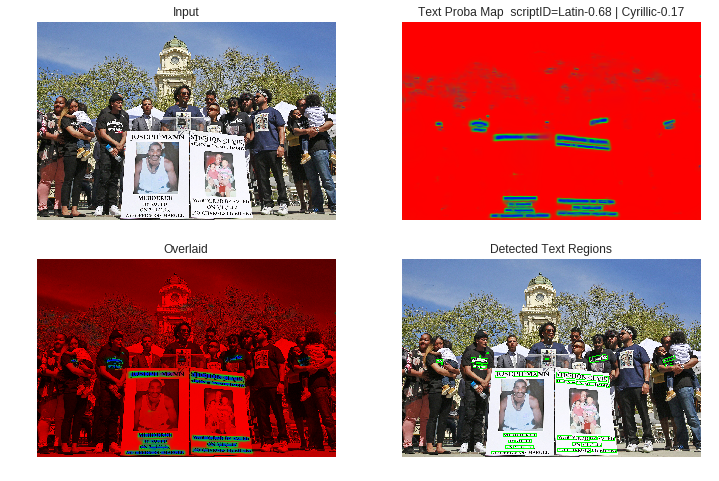

In [0]:
file_path = 'https://media2.s-nbcnews.com/i/newscms/2018_13/2383341/180331-stephon-clark-protest-ew-755p_bce3a0a92f27d0671f85d727e58139bb.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:04:49.29 | INFO: begin text detection for http://savebastionpoint.org/wp-content/uploads/2010/11/Bastion-Bottom-Line-cartoon.jpg
18-04-24 08:04:51.37 | INFO: original image size = (1176,1707)
18-04-24 08:04:51.38 | INFO: begin text detection for factor 0
18-04-24 08:04:51.38 | INFO: resize input by 0.22 to match line height (256, 371)
18-04-24 08:04:51.97 | INFO: done text detection for factor 0
18-04-24 08:04:51.99 | INFO: begin text detection for factor 1
18-04-24 08:04:51.99 | INFO: resize input by 0.63 to match line height (743, 1078)
18-04-24 08:04:54.70 | INFO: done text detection for factor 1
18-04-24 08:04:54.70 | INFO: begin text detection for factor 2
18-04-24 08:04:54.70 | INFO: resize input by 1.00 to match line height (1176, 1707)
18-04-24 08:04:59.50 | INFO: done text detection for factor 2
18-04-24 08:04:59.53 | INFO: begin text detection for factor 3
18-04-24 08:04:59.53 | INFO: resize input by 1.46 to match line height (1717, 2492)
18-04-24 08:05:08.36 | IN

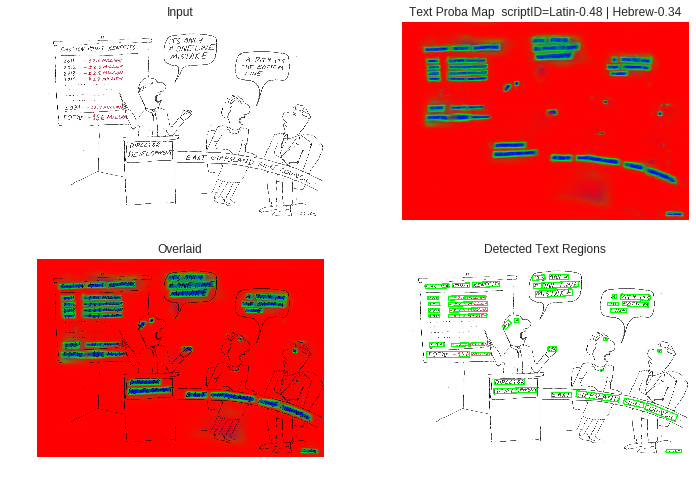

In [0]:
file_path = 'http://savebastionpoint.org/wp-content/uploads/2010/11/Bastion-Bottom-Line-cartoon.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID, num_resolutions=5 )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:05:27.93 | INFO: begin text detection for https://www.ctvnews.ca/polopoly_fs/1.134784.1337371333!/httpImage/image._gen/derivatives/landscape_620/image.
18-04-24 08:05:28.31 | INFO: original image size = (337,600)
18-04-24 08:05:28.31 | INFO: begin text detection for factor 0
18-04-24 08:05:28.31 | INFO: resize input by 0.76 to match line height (256, 455)
18-04-24 08:05:28.47 | INFO: done text detection for factor 0
18-04-24 08:05:28.47 | INFO: begin text detection for factor 1
18-04-24 08:05:28.47 | INFO: resize input by 1.27 to match line height (427, 760)
18-04-24 08:05:30.21 | INFO: done text detection for factor 1
18-04-24 08:05:30.21 | INFO: begin text detection for factor 2
18-04-24 08:05:30.22 | INFO: resize input by 1.78 to match line height (598, 1065)
18-04-24 08:05:32.46 | INFO: done text detection for factor 2
18-04-24 08:05:32.47 | INFO: begin text detection for factor 3
18-04-24 08:05:32.47 | INFO: resize input by 2.28 to match line height (769, 1370)
18-04-2

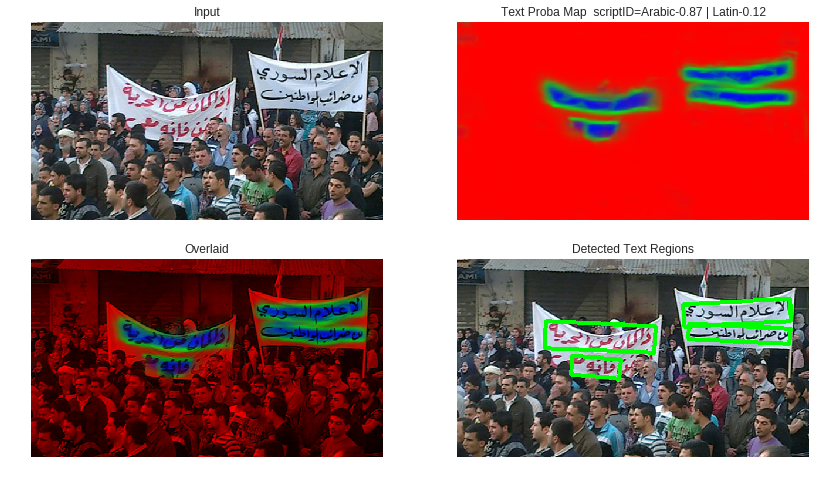

In [0]:
file_path =  'https://www.ctvnews.ca/polopoly_fs/1.134784.1337371333!/httpImage/image._gen/derivatives/landscape_620/image.'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID, num_resolutions=10 )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:06:17.03 | INFO: begin text detection for https://static.timesofisrael.com/www/uploads/2016/08/APTOPIX-Mideast-Egypt_Horo-1.jpg
18-04-24 08:06:17.93 | INFO: original image size = (576,1024)
18-04-24 08:06:17.94 | INFO: begin text detection for factor 0
18-04-24 08:06:17.94 | INFO: resize input by 0.44 to match line height (256, 455)
18-04-24 08:06:18.09 | INFO: done text detection for factor 0
18-04-24 08:06:18.10 | INFO: begin text detection for factor 1
18-04-24 08:06:18.10 | INFO: resize input by 1.11 to match line height (642, 1141)
18-04-24 08:06:18.78 | INFO: done text detection for factor 1
18-04-24 08:06:18.80 | INFO: begin text detection for factor 2
18-04-24 08:06:18.80 | INFO: resize input by 1.78 to match line height (1028, 1827)
18-04-24 08:06:20.29 | INFO: done text detection for factor 2
18-04-24 08:06:20.31 | INFO: begin text detection for factor 3
18-04-24 08:06:20.31 | INFO: resize input by 2.45 to match line height (1413, 2513)
18-04-24 08:06:23.09 | INFO

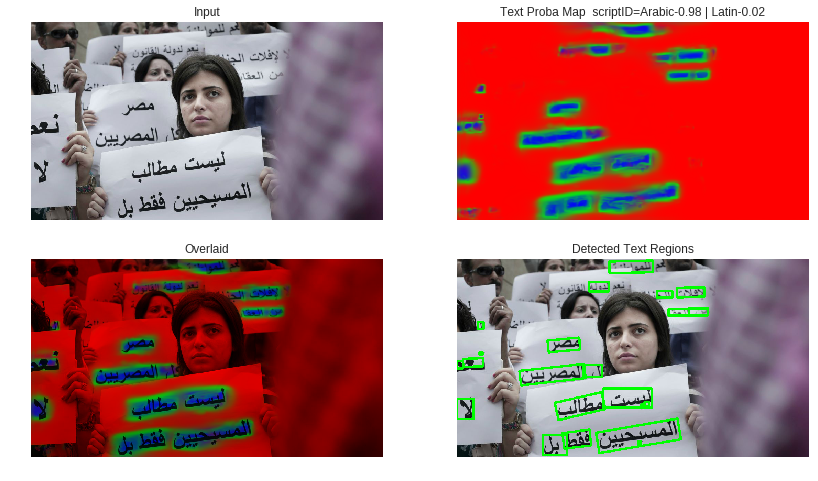

In [0]:
file_path = 'https://static.timesofisrael.com/www/uploads/2016/08/APTOPIX-Mideast-Egypt_Horo-1.jpg' 
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:06:31.97 | INFO: begin text detection for https://www.judicialwatch.org/wp-content/uploads/2014/12/Resident-Card-of-Martinez-not-contacted-1.jpg
18-04-24 08:06:34.36 | INFO: original image size = (2592,3888)
18-04-24 08:06:34.39 | INFO: begin text detection for factor 0
18-04-24 08:06:34.39 | INFO: resize input by 0.10 to match line height (256, 384)
18-04-24 08:06:34.52 | INFO: done text detection for factor 0
18-04-24 08:06:34.58 | INFO: begin text detection for factor 1
18-04-24 08:06:34.58 | INFO: resize input by 0.28 to match line height (725, 1088)
18-04-24 08:06:37.25 | INFO: done text detection for factor 1
18-04-24 08:06:37.32 | INFO: begin text detection for factor 2
18-04-24 08:06:37.32 | INFO: resize input by 0.46 to match line height (1194, 1792)
18-04-24 08:06:42.40 | INFO: done text detection for factor 2
18-04-24 08:06:42.50 | INFO: begin text detection for factor 3
18-04-24 08:06:42.50 | INFO: resize input by 0.64 to match line height (1664, 2496)
18-04-24 

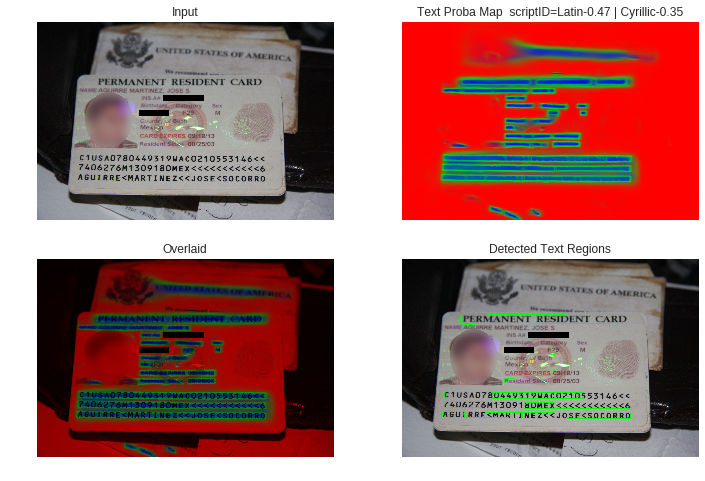

In [0]:
file_path = 'https://www.judicialwatch.org/wp-content/uploads/2014/12/Resident-Card-of-Martinez-not-contacted-1.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:07:17.65 | INFO: begin text detection for http://img-aws.ehowcdn.com/340x221p/photos.demandstudios.com/getty/article/228/44/160338344.jpg
18-04-24 08:07:17.97 | INFO: original image size = (221,340)
18-04-24 08:07:17.97 | INFO: begin text detection for factor 0
18-04-24 08:07:17.97 | INFO: resize input by 1.16 to match line height (256, 393)
18-04-24 08:07:18.11 | INFO: done text detection for factor 0
18-04-24 08:07:18.11 | INFO: begin text detection for factor 1
18-04-24 08:07:18.11 | INFO: resize input by 2.37 to match line height (523, 805)
18-04-24 08:07:20.25 | INFO: done text detection for factor 1
18-04-24 08:07:20.25 | INFO: begin text detection for factor 2
18-04-24 08:07:20.25 | INFO: resize input by 3.58 to match line height (790, 1216)
18-04-24 08:07:23.34 | INFO: done text detection for factor 2
18-04-24 08:07:23.35 | INFO: begin text detection for factor 3
18-04-24 08:07:23.35 | INFO: resize input by 4.79 to match line height (1058, 1628)
18-04-24 08:07:27.65

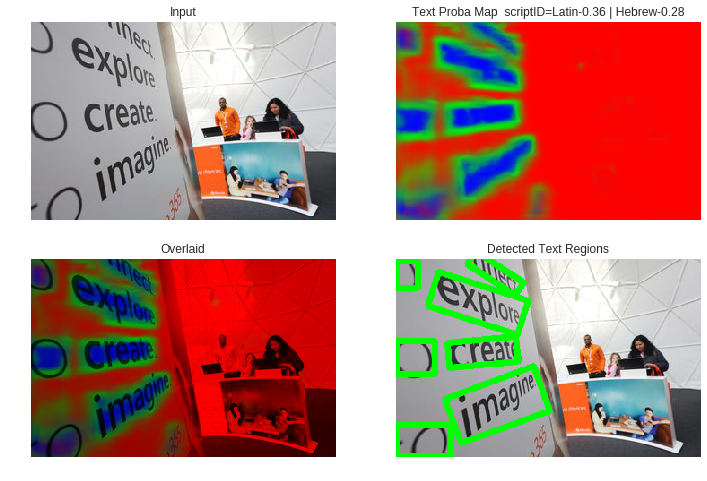

In [0]:
file_path = 'http://img-aws.ehowcdn.com/340x221p/photos.demandstudios.com/getty/article/228/44/160338344.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:07:35.46 | INFO: begin text detection for https://cdn.cnn.com/cnnnext/dam/assets/180222151147-vital-signs-jake-olson-usc-football-blind-b-00050724-full-169.jpg
18-04-24 08:07:35.69 | INFO: original image size = (900,1600)
18-04-24 08:07:35.71 | INFO: begin text detection for factor 0
18-04-24 08:07:35.71 | INFO: resize input by 0.28 to match line height (256, 455)
18-04-24 08:07:35.83 | INFO: done text detection for factor 0
18-04-24 08:07:35.85 | INFO: begin text detection for factor 1
18-04-24 08:07:35.85 | INFO: resize input by 0.71 to match line height (642, 1141)
18-04-24 08:07:36.45 | INFO: done text detection for factor 1
18-04-24 08:07:36.46 | INFO: begin text detection for factor 2
18-04-24 08:07:36.46 | INFO: resize input by 1.14 to match line height (1028, 1827)
18-04-24 08:07:37.97 | INFO: done text detection for factor 2
18-04-24 08:07:37.99 | INFO: begin text detection for factor 3
18-04-24 08:07:37.99 | INFO: resize input by 1.57 to match line height (1414, 2

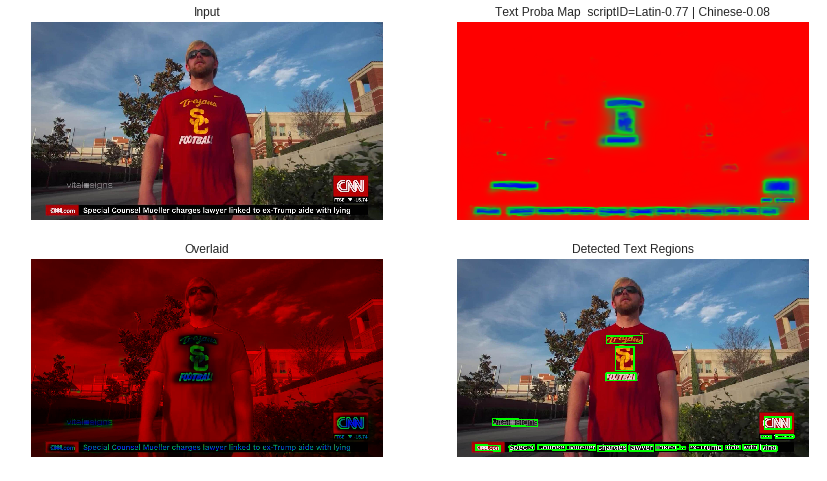

In [0]:
file_path = 'https://cdn.cnn.com/cnnnext/dam/assets/180222151147-vital-signs-jake-olson-usc-football-blind-b-00050724-full-169.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba , show_region=False, fh=4) 

# 5. Final Remarks

## 5.a Understand the similarities and differences between `SceneText` and `DocumentText` models

- Both models have been trained with respect to the same amount of data, i.e. scene + document.
- They are different for their targets: `SceneText` is optimized for **word-level** prediction, while `DocumentText` is for **line-level**.
- `SceneText` model is trained with higher weights for scene text images, and `DocumentText` model gives higher weights to document text images.

Therefore, you may use `SceneText` model for a document image, and `DocumentText` model for a scene text image. The provided `simple_decoder` and `lazy_decoder` work for both models.


### 5.a.1 SceneDet for `SceneText`

18-04-24 08:07:52.35 | INFO: begin text detection for https://cnet1.cbsistatic.com/img/H5pjNj4uKABWObDORjqmlYbMISw=/936x527/2016/06/13/4279acc4-97c0-4538-b2ae-369fe665b420/wwdc2016.jpg
18-04-24 08:07:52.58 | INFO: original image size = (527,936)
18-04-24 08:07:52.59 | INFO: begin text detection for factor 0
18-04-24 08:07:52.59 | INFO: resize input by 0.49 to match line height (256, 454)
18-04-24 08:07:52.70 | INFO: done text detection for factor 0
18-04-24 08:07:52.71 | INFO: begin text detection for factor 1
18-04-24 08:07:52.71 | INFO: resize input by 1.22 to match line height (642, 1141)
18-04-24 08:07:53.31 | INFO: done text detection for factor 1
18-04-24 08:07:53.32 | INFO: begin text detection for factor 2
18-04-24 08:07:53.32 | INFO: resize input by 1.95 to match line height (1028, 1827)
18-04-24 08:07:54.80 | INFO: done text detection for factor 2
18-04-24 08:07:54.83 | INFO: begin text detection for factor 3
18-04-24 08:07:54.83 | INFO: resize input by 2.69 to match line hei

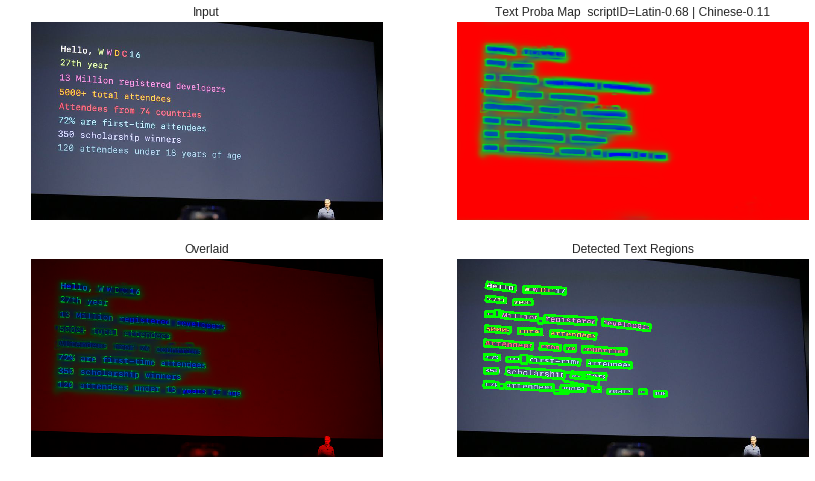

In [0]:
file_path = 'https://cnet1.cbsistatic.com/img/H5pjNj4uKABWObDORjqmlYbMISw=/936x527/2016/06/13/4279acc4-97c0-4538-b2ae-369fe665b420/wwdc2016.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

### 5.a.2 DocumDet for `SceneText`

18-04-24 08:08:10.88 | INFO: begin text detection for https://cnet1.cbsistatic.com/img/H5pjNj4uKABWObDORjqmlYbMISw=/936x527/2016/06/13/4279acc4-97c0-4538-b2ae-369fe665b420/wwdc2016.jpg
18-04-24 08:08:11.04 | INFO: original image size = (527,936)
18-04-24 08:08:11.05 | INFO: begin text detection for factor 0
18-04-24 08:08:11.05 | INFO: resize input by 0.49 to match line height (256, 454)
18-04-24 08:08:11.20 | INFO: done text detection for factor 0
18-04-24 08:08:11.21 | INFO: begin text detection for factor 1
18-04-24 08:08:11.21 | INFO: resize input by 1.22 to match line height (642, 1141)
18-04-24 08:08:11.90 | INFO: done text detection for factor 1
18-04-24 08:08:11.91 | INFO: begin text detection for factor 2
18-04-24 08:08:11.91 | INFO: resize input by 1.95 to match line height (1028, 1827)
18-04-24 08:08:13.40 | INFO: done text detection for factor 2
18-04-24 08:08:13.42 | INFO: begin text detection for factor 3
18-04-24 08:08:13.42 | INFO: resize input by 2.69 to match line hei

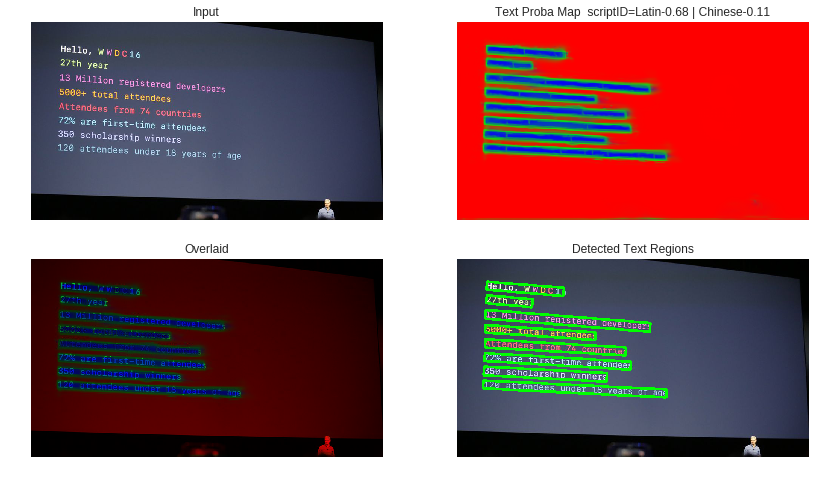

In [0]:
file_path = 'https://cnet1.cbsistatic.com/img/H5pjNj4uKABWObDORjqmlYbMISw=/936x527/2016/06/13/4279acc4-97c0-4538-b2ae-369fe665b420/wwdc2016.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, documDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

## 5.b Understand the model limitations

1. The provided decoder only uses simple connected component analysis on text regions, and thus it may be insufficient for complicated images.
2. The pretrained text detection models could tolerate the scale differences from 1 to 4. In other words, if the ratio between the largest and smallest fontsizes is greater than 4, then `simple_decoder` can't capture all text regions, and one should use `lazy_decoder` instead.

### 5.b.1 Curved text is detectable, but may not be properly corrected in decoder.

18-04-24 08:08:51.73 | INFO: begin text detection for https://theworldgame.sbs.com.au/sites/sbs.com.au.theworldgame/files/styles/full/public/socceroos_14.jpg?itok=1B873nnA
18-04-24 08:08:52.31 | INFO: original image size = (396,704)
18-04-24 08:08:52.32 | INFO: begin text detection for factor 0
18-04-24 08:08:52.32 | INFO: resize input by 0.65 to match line height (256, 455)
18-04-24 08:08:52.42 | INFO: done text detection for factor 0
18-04-24 08:08:52.43 | INFO: begin text detection for factor 1
18-04-24 08:08:52.43 | INFO: resize input by 1.62 to match line height (642, 1141)
18-04-24 08:08:53.02 | INFO: done text detection for factor 1
18-04-24 08:08:53.03 | INFO: begin text detection for factor 2
18-04-24 08:08:53.03 | INFO: resize input by 2.60 to match line height (1028, 1827)
18-04-24 08:08:54.52 | INFO: done text detection for factor 2
18-04-24 08:08:54.53 | INFO: begin text detection for factor 3
18-04-24 08:08:54.53 | INFO: resize input by 3.57 to match line height (1414, 25

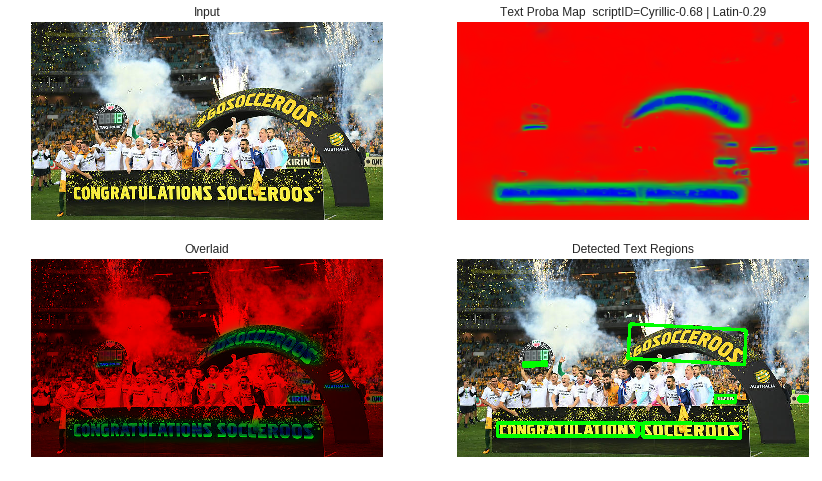

In [0]:
# pay attention to "#GOSOCCEROOS" on the arch
file_path = 'https://theworldgame.sbs.com.au/sites/sbs.com.au.theworldgame/files/styles/full/public/socceroos_14.jpg?itok=1B873nnA'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, sceneDet, scriptID )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

### 5.b.2 Extreme font sizes are detectable, but requires multi-resolution supports.

18-04-24 08:09:24.52 | INFO: begin text detection for https://1.bp.blogspot.com/-SXSsLkAEAAg/V7Jf-24H2SI/AAAAAAAACJE/S-GqoLwVnPo22rFG4CmA69oIjNhcXw_uACLcB/s1600/13938114_1033404163410001_1297177045719786705_o.jpg
18-04-24 08:09:24.59 | INFO: original image size = (1600,1066)
18-04-24 08:09:25.00 | INFO: estimated input doc paper=A4
18-04-24 08:09:25.00 | INFO: estimated dominant line height on original is 15 pixels high
18-04-24 08:09:25.00 | INFO: resize input by 1.50 to match line height 22.5
18-04-24 08:09:25.02 | INFO: begin FCN text detection
18-04-24 08:09:32.88 | INFO: done FCN text detection
18-04-24 08:09:32.88 | INFO: begin results dumping
18-04-24 08:09:32.95 | INFO: original image size = (1600,1066)
18-04-24 08:09:32.98 | INFO: resize image size = (2400,1599)
18-04-24 08:09:33.05 | INFO: localize rotated text bounding boxes
18-04-24 08:09:34.03 | INFO: begin save detection results, image mode = JPEG buffer
18-04-24 08:09:34.99 | INFO: done text detection for https://1.bp.bl

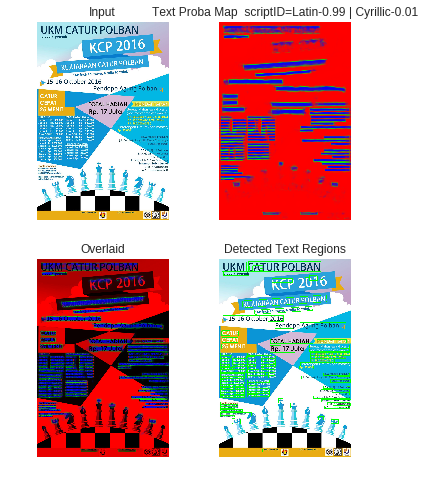

In [0]:
# decoding with only one resolution - simple decoder
file_path='https://1.bp.blogspot.com/-SXSsLkAEAAg/V7Jf-24H2SI/AAAAAAAACJE/S-GqoLwVnPo22rFG4CmA69oIjNhcXw_uACLcB/s1600/13938114_1033404163410001_1297177045719786705_o.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.simple_decoder( file_path, documDet, scriptID, dark_text=True, rotated_text=True )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

In [0]:
# decoding with multi-resolutions - lazy decoder
file_path='https://1.bp.blogspot.com/-SXSsLkAEAAg/V7Jf-24H2SI/AAAAAAAACJE/S-GqoLwVnPo22rFG4CmA69oIjNhcXw_uACLcB/s1600/13938114_1033404163410001_1297177045719786705_o.jpg'
output_lut, (text_proba, script_proba) =  textDetDec.lazy_decoder( file_path, documDet, scriptID, num_resolutions=2 )
textDetDec.parse_detection_results( file_path, output_lut, text_proba, script_proba, show_region=False, fh=4 ) 

18-04-24 08:09:37.12 | INFO: begin text detection for https://1.bp.blogspot.com/-SXSsLkAEAAg/V7Jf-24H2SI/AAAAAAAACJE/S-GqoLwVnPo22rFG4CmA69oIjNhcXw_uACLcB/s1600/13938114_1033404163410001_1297177045719786705_o.jpg
18-04-24 08:09:37.19 | INFO: original image size = (1600,1066)
18-04-24 08:09:37.19 | INFO: begin text detection for factor 0
18-04-24 08:09:37.20 | INFO: resize input by 0.24 to match line height (384, 256)
18-04-24 08:09:37.79 | INFO: done text detection for factor 0
18-04-24 08:09:37.83 | INFO: begin text detection for factor 1
18-04-24 08:09:37.83 | INFO: resize input by 2.00 to match line height (3200, 2132)
18-04-24 08:09:51.18 | INFO: done text detection for factor 1
18-04-24 08:09:51.18 | INFO: begin text detection for factor 2
18-04-24 08:09:51.18 | INFO: resize input by 1.00 to match line height (1600, 1066)
